Updated linear regression versus stochastic gradient descent for real estate data (above ground livable area vs. sale price). The update includes allowing for efficient batching of data and visualization of learning rate convergence issues. SF 26MAR2024

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

In [2]:
# load in (reduced) Kaggle dataset - contains sale price & above ground square feet of many houses
! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')

In [3]:
# view the df
data.head()

,Unnamed: 0,SalePrice,GrLivArea
0,1,181500,1262
1,7,200000,2090
2,9,118000,1077
3,12,144000,912
4,15,132000,854


<AxesSubplot: xlabel='GrLivArea'>

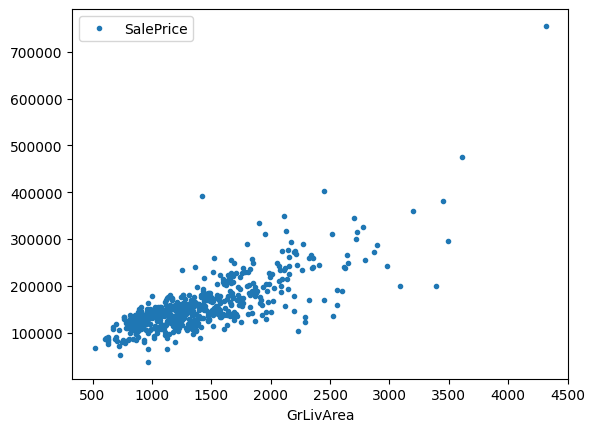

In [4]:
# visualize data
data.plot(x='GrLivArea', y='SalePrice',style='.')

Calculate the linear regression according to the derivation of y = mx + b. 

As defined by: $$m = { n (\Sigma xy) - (\Sigma x) (\Sigma y) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

$$b = { (\Sigma y) (\Sigma x^2) - (\Sigma x) (\Sigma xy) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

In [5]:
# calculate a linear regression line using derivation

#obtain necessary values

# number of points
n = len(data)

# arrays of x and y values
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()

# calculate sum of x*y, sum of all x, sum of all y, and sum of x^2
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)

# calculate the denominators (which are the same for both m and b
denominator = n * sum_x2 - sum_x * sum_x

In [6]:
# calculate the fit values for m and b as described by above equation
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# save the calculated values for comparison during training to evaluate loss
m_calc = m
b_calc = b

y = 87.688145 * x + 34754.077892


In [7]:
# define plotting function for visualization for data vs fitted model
# this plotting function is updated from the original notebook to include functionality to plot as 
# a stand alone plot or be incorporated in a subplot
def plot_data(x, y, m, b, plt_obj=None):
    if plt_obj is None:
        # if plt_obj is not provided, use the global plt to create a figure and axes
        fig, ax = plt.subplots()
    else:
        # if plt_obj is provided, use it as the axes
        ax = plt_obj

    # plot data points and fitted model
    ax.plot(x, y, 'bo', label='Data')  # blue circles for data points
    linear_x = np.arange(x.min(), x.max())
    linear_y = linear_x * m + b
    ax.plot(linear_x, linear_y, 'r-', label='Fitted model')  # red line for linear fit
    
    # set labels
    ax.set_xlabel("Square Footage")
    ax.set_ylabel("Sale Price")
    
    # Show legend
    ax.legend()

    # show plot when using global plt and plt_obj is None
    if plt_obj is None:
        plt.legend()
        plt.show()

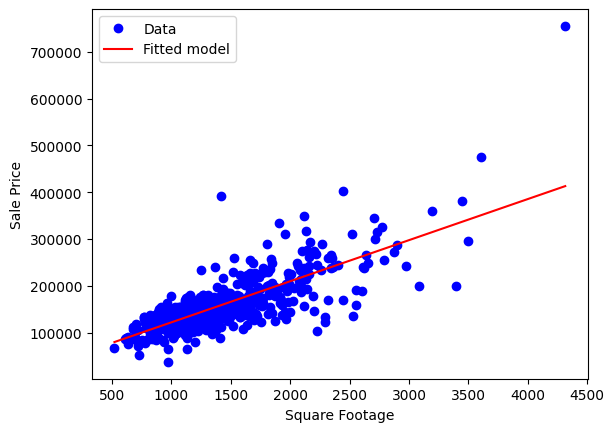

In [8]:
# visualize data vs fit
plot_data(x,y,m,b)

In [9]:
# move forward with modeling using stochastic gradient descent
# results will be compared to our derived regression line

In [10]:
# define model which will predict y
def model(x,m,b):
   return m * x + b

In [11]:
# define loss function (here this is the mean squared error) which we will use to optimize predicted y values
def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

In [12]:
# functions to update our m and b parameters
def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.mean(dL_db)
   return b - learning_rate * dL_db

In [13]:
# calculate slope and intercept
m = 5.
b = 1000.
print('y_i = %.2f * x + %.2f' % (m,b))

# calculate associated loss
l = loss(x,y,m,b)
print('first 10 loss values: ',l[:10])

y_i = 5.00 * x + 1000.00
first 10 loss values:  [3.03421561e+10 3.55511025e+10 1.24579082e+10 1.91656336e+10
 1.60604929e+10 2.04432804e+10 1.72410030e+10 1.76517796e+10
 1.52769600e+10 2.18152900e+10]


y_i = 5.47 * x + 1000.00     previously calculated: y_i = 87.69 * x + 34754.08


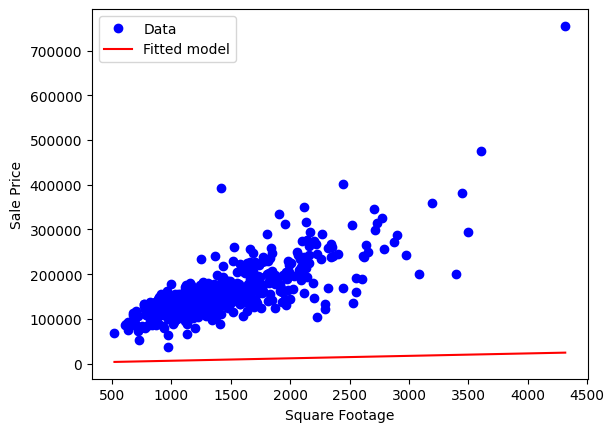

In [14]:
# define a learning rate for both m and b, then calculate them and visualize in plot
learning_rate = 1e-9
m = updated_m(x,y,m,b,learning_rate)
b = updated_b(x,y,m,b,learning_rate)
print('y_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f' % (m,b,m_calc,b_calc))
plot_data(x,y,m,b)

[029]  dy_i = 88.89 * x + 32912.24     previously calculated: y_i = 87.69 * x + 34754.08    loss: 1478200827.641291


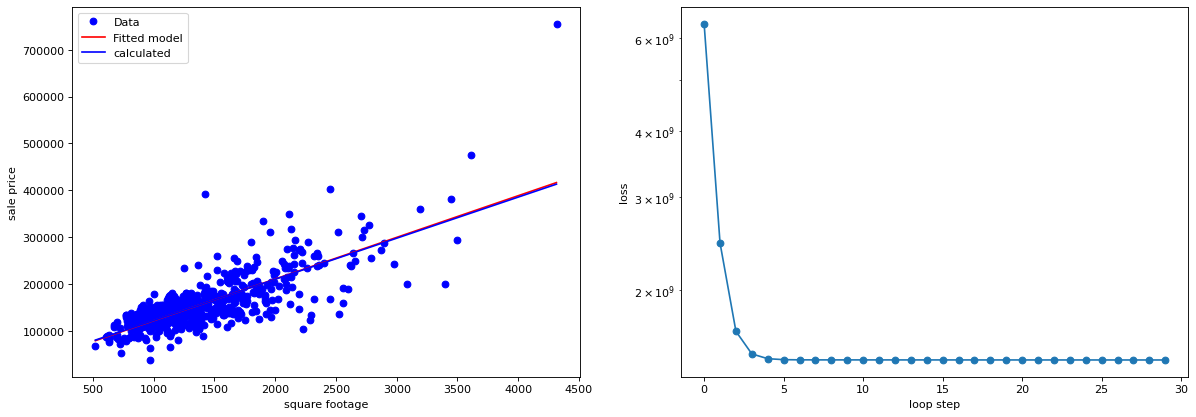

In [15]:
# original visualization of the calculated model as we loop through the data N times
# set our initial slope and intercept
m = 5.
b = 1000.
# batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []
# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()
# we run our loop N times
loop_N = 30
for i in range(loop_N):
   # update our slope and intercept based on the current values
   m = updated_m(data_x,data_y,m,b,learning_rate_m)
   b = updated_b(data_x,data_y,m,b,learning_rate_b)

   # calculate the loss value
   loss_value = np.mean(loss(data_x,data_y,m,b))

   # keep a history of our loss values
   loss_history.append(loss_value)

   # print our progress
   print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (i,m,b,m_calc,b_calc,loss_value))
   
   # close/delete previous plots
   plt.close('all')
   
   # create a 1 by 2 plot grid
   fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
   # lot our usual output
   plot_data(data_x,data_y,m,b,ax[0])

   # here we also plot the calculated linear fit for comparison
   line_x = np.arange(data_x.min(),data_x.max())
   line_y = line_x * m_calc + b_calc
   ax[0].plot(line_x,line_y,'b-',label='calculated')
   # add a legend to the plot and x/y labels
   ax[0].legend()
   ax[0].set_xlabel('square footage')
   ax[0].set_ylabel('sale price')

   # plot the loss 
   loss_x = np.arange(0,len(loss_history))
   loss_y = np.asarray(loss_history)
   ax[1].plot(loss_x,loss_y, 'o-')
   ax[1].set_yscale('log')
   ax[1].set_xlabel('loop step')
   ax[1].set_ylabel('loss')
   plt.show()
   # gives us time to see the plot
   time.sleep(2.5)
   # clears the plot when the next plot is ready to show.
   ipydis.clear_output(wait=True)

[000] dy_i = 52.84 * x + 18029.01 previously calculated: y_i = 87.69 * x + 34754.08 loss: 7441971227.575616
[001] dy_i = 73.62 * x + 25729.00 previously calculated: y_i = 87.69 * x + 34754.08 loss: 3591000644.421726
[002] dy_i = 82.57 * x + 29340.19 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2859371050.382919
[003] dy_i = 86.33 * x + 31156.54 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2720898991.189007
[004] dy_i = 87.83 * x + 32182.35 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2694166554.652240
[005] dy_i = 88.34 * x + 32857.34 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2688059983.541825
[006] dy_i = 88.42 * x + 33374.10 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2685605577.367579
[007] dy_i = 88.32 * x + 33817.03 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2683757532.584335
[008] dy_i = 88.14 * x + 34223.16 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2682019396.283114
[009] dy_i = 87.93 * x + 346

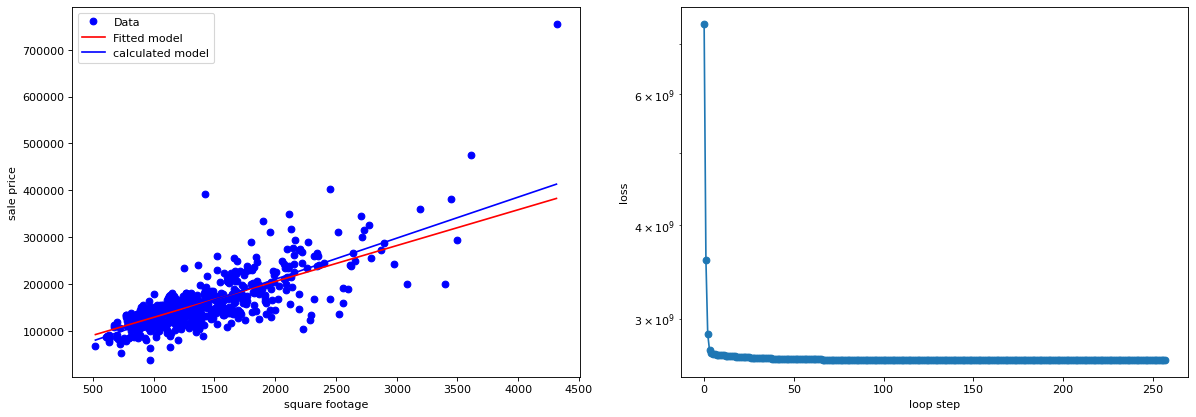

In [16]:
# updating the previous logic to work with various batch sizes
# first batch size is 64

# set our initial slope and intercept
m = 5.
b = 1000.
batch_size = 64

# set initial learning rates
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# use these to plot our progress over time
loss_history = []

# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()

# sample a fixed batch
fixed_batch = data.sample(n=batch_size, replace=True)
fixed_batch_x = fixed_batch['GrLivArea'].to_numpy()
fixed_batch_y = fixed_batch['SalePrice'].to_numpy()

# we run our loop N times
loop_N = 30 * (data['GrLivArea'].shape[0]) // batch_size

for i in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(fixed_batch_x, fixed_batch_y, m, b, learning_rate_m)
    b = updated_b(fixed_batch_x, fixed_batch_y, m, b, learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(fixed_batch_x, fixed_batch_y, m, b))

    # keep a history of our loss values
    loss_history.append(loss_value)

    # print our progress
    print('[%03d] dy_i = %.2f * x + %.2f previously calculated: y_i = %.2f * x + %.2f loss: %f' % (i, m, b, m_calc, b_calc, loss_value))

# close/delete previous plots
plt.close('all')

# create a 1 by 2 plot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# plot our usual output
plot_data(data_x, data_y, m, b, ax[0])

# here we also plot the calculated linear fit for comparison
line_x = np.arange(data_x.min(), data_x.max())
line_y = line_x * m_calc + b_calc
ax[0].plot(line_x, line_y, 'b-', label='calculated model')

# add a legend to the plot and x/y labels
ax[0].legend()
ax[0].set_xlabel('square footage')
ax[0].set_ylabel('sale price')

# plot the loss
loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].plot(loss_x, loss_y, 'o-')
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')

plt.show()

[000] dy_i = 52.07 * x + 18434.00 previously calculated: y_i = 87.69 * x + 34754.08 loss: 7340580903.693741
[001] dy_i = 73.90 * x + 26379.39 previously calculated: y_i = 87.69 * x + 34754.08 loss: 3044655944.092789
[002] dy_i = 84.05 * x + 29942.84 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2123166206.914802
[003] dy_i = 88.81 * x + 31483.84 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1924268413.165834
[004] dy_i = 91.08 * x + 32092.59 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1880629777.074073
[005] dy_i = 92.20 * x + 32272.74 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1870594027.639807
[006] dy_i = 92.78 * x + 32256.97 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1867946341.117755
[007] dy_i = 93.11 * x + 32152.76 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1866980244.677430
[008] dy_i = 93.33 * x + 32009.71 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1866427477.549276
[009] dy_i = 93.49 * x + 318

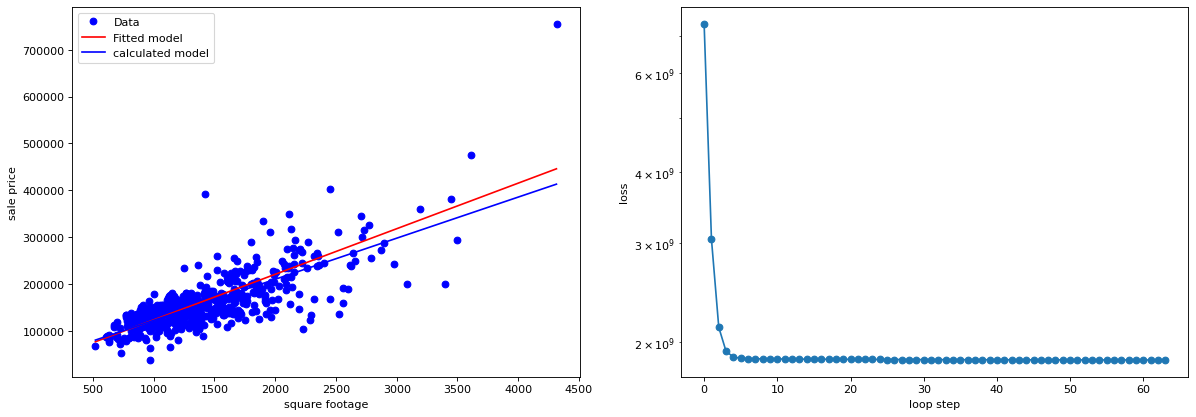

In [17]:
# Now for a batch size of 256

# set our initial slope and intercept
m = 5.
b = 1000.
batch_size = 256

# set initial learning rates
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# use these to plot our progress over time
loss_history = []

# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()

# sample a fixed batch
fixed_batch = data.sample(n=batch_size, replace=True)
fixed_batch_x = fixed_batch['GrLivArea'].to_numpy()
fixed_batch_y = fixed_batch['SalePrice'].to_numpy()

# we run our loop N times
loop_N = 30 * (data['GrLivArea'].shape[0]) // batch_size

for i in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(fixed_batch_x, fixed_batch_y, m, b, learning_rate_m)
    b = updated_b(fixed_batch_x, fixed_batch_y, m, b, learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(fixed_batch_x, fixed_batch_y, m, b))

    # keep a history of our loss values
    loss_history.append(loss_value)

    # print our progress
    print('[%03d] dy_i = %.2f * x + %.2f previously calculated: y_i = %.2f * x + %.2f loss: %f' % (i, m, b, m_calc, b_calc, loss_value))

# close/delete previous plots
plt.close('all')

# create a 1 by 2 plot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# plot our usual output
plot_data(data_x, data_y, m, b, ax[0])

# here we also plot the calculated linear fit for comparison
line_x = np.arange(data_x.min(), data_x.max())
line_y = line_x * m_calc + b_calc
ax[0].plot(line_x, line_y, 'b-', label='calculated model')

# add a legend to the plot and x/y labels
ax[0].legend()
ax[0].set_xlabel('square footage')
ax[0].set_ylabel('sale price')

# plot the loss
loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].plot(loss_x, loss_y, 'o-')
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')

plt.show()

[000] dy_i = 51.45 * x + 18121.11 previously calculated: y_i = 87.69 * x + 34754.08 loss: 6477096488.822462
[001] dy_i = 72.40 * x + 25922.09 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2517700568.168534
[002] dy_i = 81.83 * x + 29510.11 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1711180172.253395
[003] dy_i = 86.05 * x + 31193.17 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1547317883.744588
[004] dy_i = 87.91 * x + 32014.26 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1514162179.968140
[005] dy_i = 88.72 * x + 32444.73 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1507463980.315156
[006] dy_i = 89.04 * x + 32697.62 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1506066859.345111
[007] dy_i = 89.15 * x + 32869.20 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1505709241.799045
[008] dy_i = 89.16 * x + 33003.02 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1505546910.058558
[009] dy_i = 89.13 * x + 331

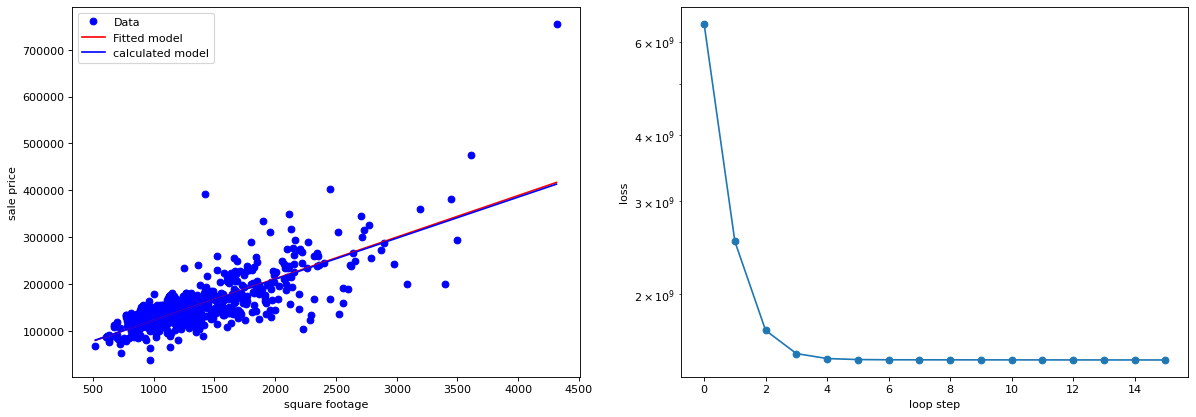

In [18]:
# now for batch size of 1024

# set our initial slope and intercept
m = 5.
b = 1000.
batch_size = 1024

# set initial learning rates
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# use these to plot our progress over time
loss_history = []

# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()

# sample a fixed batch
fixed_batch = data.sample(n=batch_size, replace=True)
fixed_batch_x = fixed_batch['GrLivArea'].to_numpy()
fixed_batch_y = fixed_batch['SalePrice'].to_numpy()

# we run our loop N times
loop_N = 30 * (data['GrLivArea'].shape[0]) // batch_size

for i in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(fixed_batch_x, fixed_batch_y, m, b, learning_rate_m)
    b = updated_b(fixed_batch_x, fixed_batch_y, m, b, learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(fixed_batch_x, fixed_batch_y, m, b))

    # keep a history of our loss values
    loss_history.append(loss_value)

    # print our progress
    print('[%03d] dy_i = %.2f * x + %.2f previously calculated: y_i = %.2f * x + %.2f loss: %f' % (i, m, b, m_calc, b_calc, loss_value))

# close/delete previous plots
plt.close('all')

# create a 1 by 2 plot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# plot our usual output
plot_data(data_x, data_y, m, b, ax[0])

# here we also plot the calculated linear fit for comparison
line_x = np.arange(data_x.min(), data_x.max())
line_y = line_x * m_calc + b_calc
ax[0].plot(line_x, line_y, 'b-', label='calculated model')

# add a legend to the plot and x/y labels
ax[0].legend()
ax[0].set_xlabel('square footage')
ax[0].set_ylabel('sale price')

# plot the loss
loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].plot(loss_x, loss_y, 'o-')
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')

plt.show()

[000] dy_i = 51.69 * x + 17861.54 previously calculated: y_i = 87.69 * x + 34754.08 loss: 6345018035.314284
[001] dy_i = 72.56 * x + 25473.27 previously calculated: y_i = 87.69 * x + 34754.08 loss: 2451191834.268871
[002] dy_i = 81.87 * x + 28941.51 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1672226766.571803
[003] dy_i = 85.99 * x + 30553.02 previously calculated: y_i = 87.69 * x + 34754.08 loss: 1516793221.630460


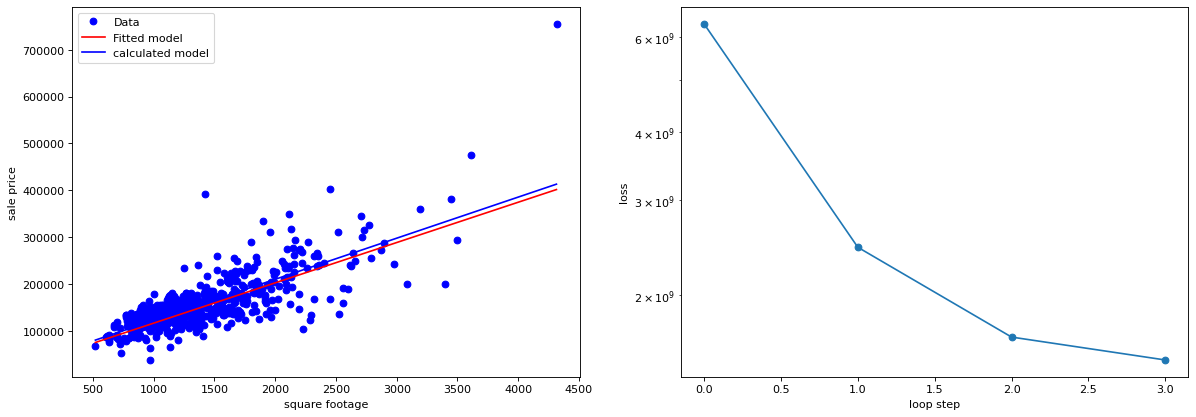

In [19]:
# finally, a batch size of 4096

# set our initial slope and intercept
m = 5.
b = 1000.
batch_size = 4096

# set initial learning rates
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# use these to plot our progress over time
loss_history = []

# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()

# sample a fixed batch
fixed_batch = data.sample(n=batch_size, replace=True)
fixed_batch_x = fixed_batch['GrLivArea'].to_numpy()
fixed_batch_y = fixed_batch['SalePrice'].to_numpy()

# we run our loop N times
loop_N = 30 * (data['GrLivArea'].shape[0]) // batch_size

for i in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(fixed_batch_x, fixed_batch_y, m, b, learning_rate_m)
    b = updated_b(fixed_batch_x, fixed_batch_y, m, b, learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(fixed_batch_x, fixed_batch_y, m, b))

    # keep a history of our loss values
    loss_history.append(loss_value)

    # print our progress
    print('[%03d] dy_i = %.2f * x + %.2f previously calculated: y_i = %.2f * x + %.2f loss: %f' % (i, m, b, m_calc, b_calc, loss_value))

# close/delete previous plots
plt.close('all')

# create a 1 by 2 plot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# plot our usual output
plot_data(data_x, data_y, m, b, ax[0])

# here we also plot the calculated linear fit for comparison
line_x = np.arange(data_x.min(), data_x.max())
line_y = line_x * m_calc + b_calc
ax[0].plot(line_x, line_y, 'b-', label='calculated model')

# add a legend to the plot and x/y labels
ax[0].legend()
ax[0].set_xlabel('square footage')
ax[0].set_ylabel('sale price')

# plot the loss
loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].plot(loss_x, loss_y, 'o-')
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')

plt.show()

Final Progress for Batch Size: 64, Learning Rate (m): 1e-07, Learning Rate (b): 0.1
dy_i = 81.07 * x + 45587.93 loss: 1098393801.652478


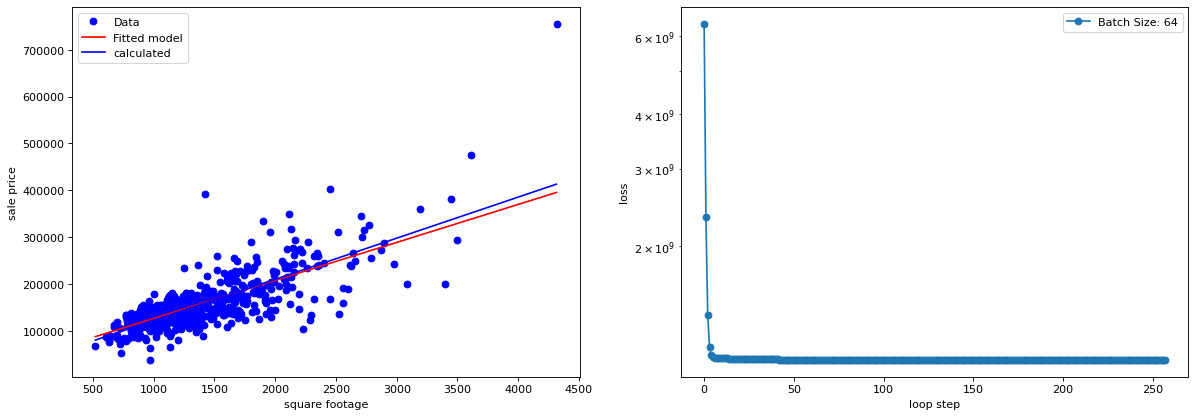

Final Progress for Batch Size: 256, Learning Rate (m): 4e-07, Learning Rate (b): 0.4
dy_i = 81.19 * x + 39191.07 loss: 1579880112.441752


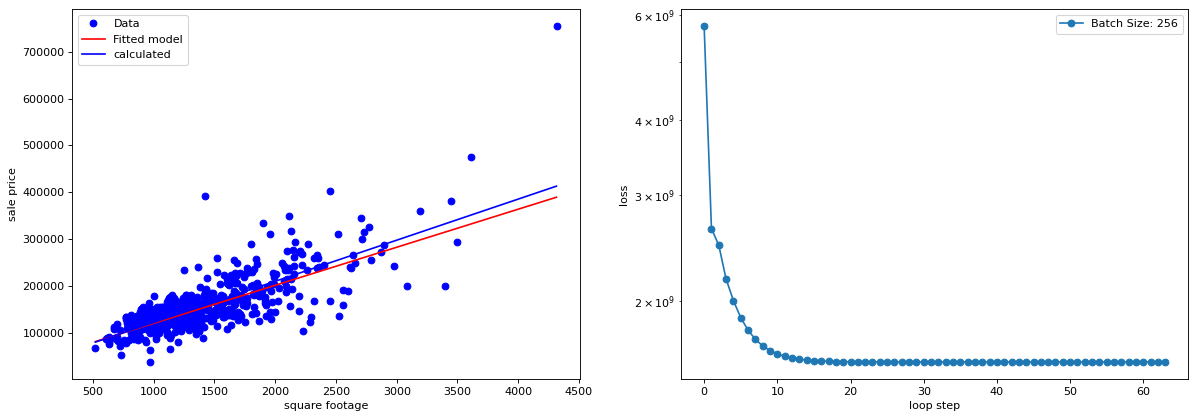

Final Progress for Batch Size: 1024, Learning Rate (m): 1.6e-06, Learning Rate (b): 1.6
dy_i = 3899519210636418048.00 * x + -14917179290332975595520.00 loss: 91491448410729563036224535828289018348437504.000000


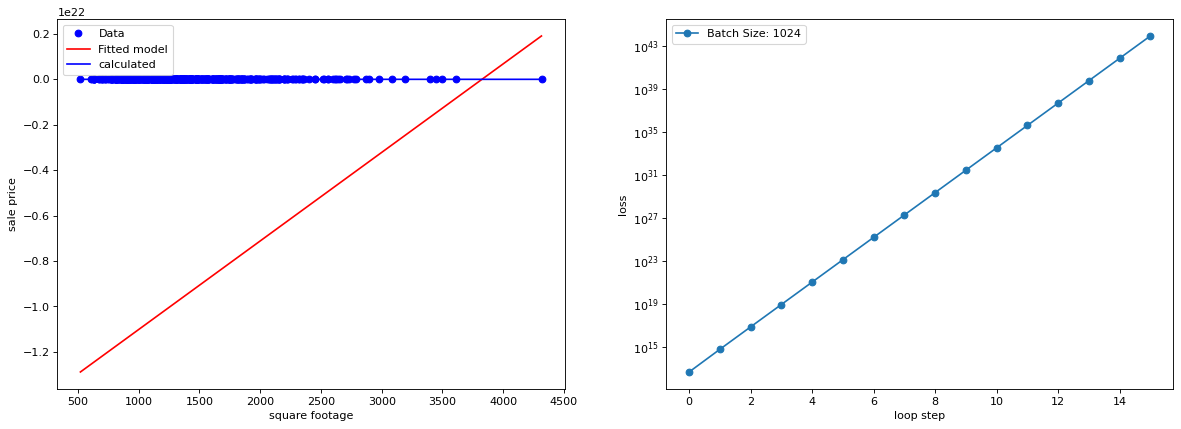

Final Progress for Batch Size: 2048, Learning Rate (m): 3.2e-06, Learning Rate (b): 3.2
dy_i = 4175872749244609.50 * x + -34174523088047398912.00 loss: 808284061085846080084472375806907121664.000000


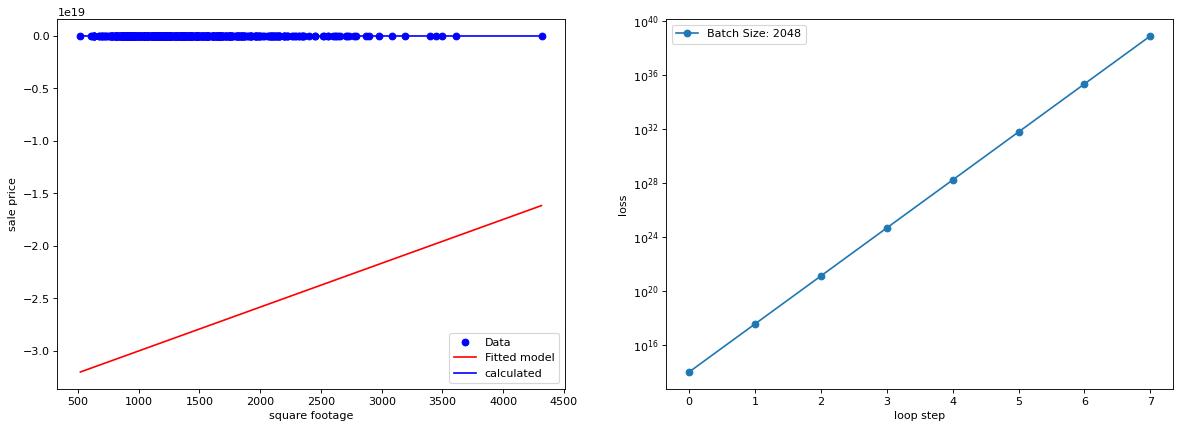

In [20]:
## Bonus: we will scale the batch size and learning rate linearly and observe its impact on convergence

# set our initial slope and intercept
m = 5.
b = 1000.

# set initial learning rates and batch size
initial_batch_size = 64
initial_learning_rate_m = 1e-7
initial_learning_rate_b = 1e-1

# use these to plot our progress over time
loss_histories = []

# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()

# loop over different batch sizes and learning rates
for factor in [1, 4, 16, 32]:
    batch_size = initial_batch_size * factor
    learning_rate_m = initial_learning_rate_m * factor
    learning_rate_b = initial_learning_rate_b * factor

    # sample a fixed batch
    fixed_batch = data.sample(n=batch_size, replace=True)
    fixed_batch_x = fixed_batch['GrLivArea'].to_numpy()
    fixed_batch_y = fixed_batch['SalePrice'].to_numpy()

    # reset slope and intercept
    m = 5.
    b = 1000.

    # we run our loop N times
    loop_N = 30 * (data['GrLivArea'].shape[0]) // batch_size
    loss_history = []

    for i in range(loop_N):
        # update our slope and intercept based on the current values
        m = updated_m(fixed_batch_x, fixed_batch_y, m, b, learning_rate_m)
        b = updated_b(fixed_batch_x, fixed_batch_y, m, b, learning_rate_b)

        # calculate the loss value
        loss_value = np.mean(loss(fixed_batch_x, fixed_batch_y, m, b))

        # keep a history of our loss values
        loss_history.append(loss_value)

        # print our progress
        #print('[%03d] dy_i = %.2f * x + %.2f previously calculated: y_i = %.2f * x + %.2f loss: %f' % (i, m, b, m_calc, b_calc, loss_value))

    loss_histories.append(loss_history)

    # close/delete previous plots
    plt.close('all')

    # create a 1 by 2 plot grid
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

    # plot our usual output
    plot_data(data_x, data_y, m, b, ax[0])

    # here we also plot the calculated linear fit for comparison
    line_x = np.arange(data_x.min(), data_x.max())
    line_y = line_x * m_calc + b_calc
    ax[0].plot(line_x, line_y, 'b-', label='calculated')

    # add a legend to the plot and x/y labels
    ax[0].legend()
    ax[0].set_xlabel('square footage')
    ax[0].set_ylabel('sale price')

    # plot the loss
    loss_x = np.arange(0, len(loss_history))
    loss_y = np.asarray(loss_history)
    ax[1].plot(loss_x, loss_y, 'o-', label=f'Batch Size: {batch_size}')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('loop step')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    # print the final progress
    print(f'Final Progress for Batch Size: {batch_size}, Learning Rate (m): {learning_rate_m}, Learning Rate (b): {learning_rate_b}')
    print(f'dy_i = {m:.2f} * x + {b:.2f} loss: {loss_history[-1]:.6f}')

    plt.show()

In [21]:
# we can see that as we scale the learning rate and batch size linearly, we do not reach convergence